# Fraud: A guide how-to
## Nicolas Gort Freitas


In [740]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats
import math

from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KernelDensity

sns.set()

## Auxiliary functions

In [861]:
def logshift(series):
    """
    1) Shifts data by 1-min(X) to restrict image set
    to positive reals
    2) Apply log
    """
    minimum = min(series)
    
    
    return np.log(series - minimum + 1)

def estimate_density(X, a, b, n, folds=10):
    """
    adapted from http://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html#sphx-glr-auto-examples-neighbors-plot-kde-1d-py
    
    Arguments:
    
    X (Pandas Series): data to estimate density of
    a (float): Lower bound of the Bandwidth space to sample from
    b (float): Upper bound of the Bandwidth space to sample from
    n (int): Number of elements in the Bandwidth space
    folds (int): Number of k-folds for CV
    Returns:
    
    fitted kernel
    
    calls density + histogram plot
    """
    
    kde = GridSearchCV(KernelDensity(),
                       {'bandwidth' : np.logspace(a,b,n),
                        'kernel' : ['gaussian','tophat']},
                        verbose=1,cv=folds)
    
    kde.fit(np.array(X).reshape(-1,1))
    return kde
    
    
def plot_density(X, kde, title, bins,kernel=None,ylog=False):
    """
    X (Pandas Series): data to estimate density of
    kde: fitted kernel
    bins (int): number of bins in plot
    title (str): title of returned plot
    kernel (Default: 'gaussian') (str): name of kernel

    Returns:
    density + histogram + rug plot

    """
    kde.best_estimator_.fit(np.array(X).reshape(-1,1))
    
    X_plot = np.linspace(min(X), max(X), 2000).reshape(-1,1)
    
    log_dens = kde.best_estimator_.score_samples(X_plot)


    label = 'Kernel: ' + kde.best_params_['kernel'] +\
        '\nBandwidth: ' + str(round(kde.best_params_['bandwidth'],2))
        
    plt.hist(X,density=True,bins=bins)
    plt.plot(X_plot.reshape(-1),np.exp(log_dens), label=label)
    sns.rugplot(np.array(X), color='k',alpha=0.2)

    plt.legend()
    plt.title(title)
    plt.ylabel('Density')
    
    if ylog:
        plt.yscale('log')


    plt.show()


## Data loading & setup

In [742]:
data = pd.read_csv('anonymized.csv', parse_dates=True)
data.Date = pd.to_datetime(data.Date, format='%d%b%Y')
data = data.sort_values('Date')

data['Day']=data.Date.apply(lambda x: x.day)
data['Month'] = data.Date.apply(lambda x : x.month)
data['Year'] = data.Date.apply(lambda x : x.year)
data['Log_amount'] = logshift(data.Amount)

monthly_transactions = data.groupby([data.Year, data.Month]).agg('count')
monthly_transactions = monthly_transactions.loc[:,['Amount']]

### Number of transactions that occur in a single month

Fitting 20 folds for each of 200 candidates, totalling 4000 fits


[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    2.9s finished


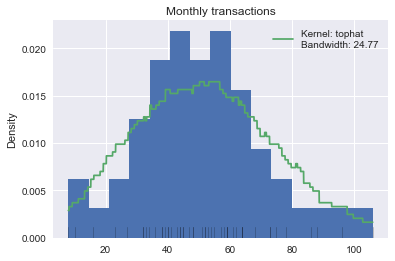

In [864]:
kd_monthly = estimate_density(monthly_transactions.Amount, a=-2, b=2, n = 100, folds=20)
plot_density(monthly_transactions.Amount,kde=kd_monthly, title='Monthly transactions',bins=15)

### Days in the month that transactions occur on

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    7.1s finished


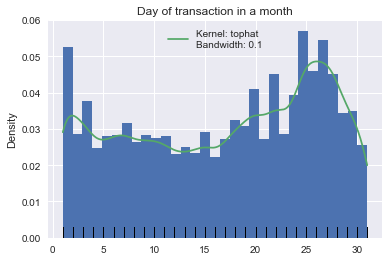

In [529]:
kd_day = estimate_density(data.Day, a=-2, b=2, n = 40)
plot_density(data.Day,kde=kd_day, title='Day of transaction in a month',bins=31)

### Transaction size

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed:   11.8s finished


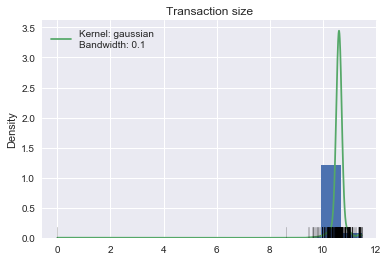

In [862]:
kd_amount = estimate_density(data.Log_amount, a=-5, b=-1, n = 40, folds=10)
plot_density(data.Log_amount,kde=kd_amount, title='Transaction size',bins=15)

## A month of synthetic transactions

### Generation

In [865]:
def gen_synth_data(folds=1):
    n_transactions = int(np.mean(kd_monthly.best_estimator_.sample()))*folds
    days = kd_day.best_estimator_.sample(n_transactions).astype(int).reshape(-1)

    logshifted_amounts = kd_amount.best_estimator_.sample(n_transactions).reshape(-1)
    amounts =  np.exp(logshifted_amounts) - 1 + min(data.Amount)

    return pd.DataFrame({'Day' : days,
                        'Amount' : amounts})



### Comparison with real data

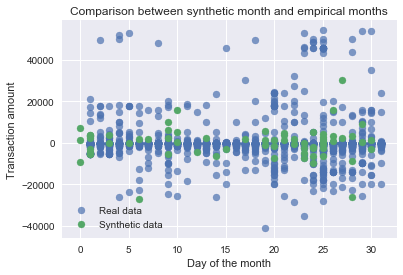

In [873]:
synth_data = gen_synth_data(1)
plt.scatter(data.Day,data.Amount, label='Real data', alpha=0.7)
plt.scatter(synth_data.Day, synth_data.Amount, label='Synthetic data')
plt.legend()
plt.title('Comparison between synthetic month and empirical months')
plt.xlabel('Day of the month')
plt.ylabel('Transaction amount')
plt.show()

## Leading digit analysis

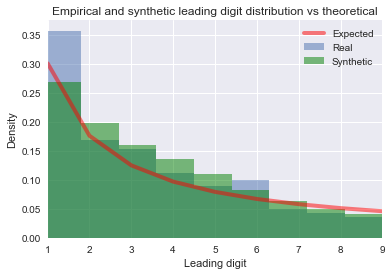


As it can be observed from the plot, the real data is slightly deficient in large 
leading digits, and has significantly more 1s than expected as per Benford's law. 
The synthetic data has slightly excesive density of 2s, 3s, 4s and 5s, which is
balanced by a slightly lower than expected number of 1s, 7s, 8s and 9s.
Overall, there is no significant clue to the untrained eye that syuggests the 
synthetic data does not follow Benford's law. In fact, one could even argue
that it follows it even better than the real data.



In [893]:
synth_digits = [int(str(abs(x))[0]) for x in gen_synth_data(10000).Amount]
real_digits = [int(str(abs(x))[0]) for x in data.Amount]
benford_digits = np.vectorize(lambda d : math.log10(1+1/d))(np.arange(1,10))

plt.plot(np.arange(1,10),benford_digits,alpha=0.5,label='Expected',linewidth=4, color='r')
plt.hist(real_digits,density=True,alpha=0.5, label='Real')
plt.hist(synth_digits,density=True,alpha=0.5, label='Synthetic', color='green')

plt.ylabel('Density')
plt.xlabel('Leading digit')
plt.xlim(1,9)
plt.title('Empirical and synthetic leading digit distribution vs theoretical')
plt.legend()
plt.show()



print("""
As it can be observed from the plot, the real data is slightly deficient in large 
leading digits, and has significantly more 1s than expected as per Benford's law. 
The synthetic data has slightly excesive density of 2s, 3s, 4s and 5s, which is
balanced by a slightly lower than expected number of 1s, 7s, 8s and 9s.
Overall, there is no significant clue to the untrained eye that syuggests the 
synthetic data does not follow Benford's law. In fact, one could even argue
that it follows it even better than the real data.
""")

## Discusion

Kernel Density Estimation allows us to create synthetic data based on the density of our  
original data, yet the simplicity of the model hereby developed prevents it from  
incorporating nuances of real data that a financial detective is likely to be aware of.

The main flaw of this generative model is that it samples monthly volumes, dates and amounts  
independently, which is naive. A more robust model should estimate the joint distribution  
of days of transactions, monthly amounts and transaction amounts. This would capture   
month-specific events, such as national holidays and paydays, as well as other types of   
conditional dependence between the variables. However, this would also increase the  
risk of overfitting, given that it would increase the dispersion of the data.    
Thus, to build such a model we would require larger volumes of empirical data.

Another addition would be extracting the day of the week of each data point from the  
original data. This would allow us to incorporate the intrinsic variation in the  
transactions throughout the week. The importance of this factor is reflected by the  
fact that there are no transactions on Sundays, as illustrated below.

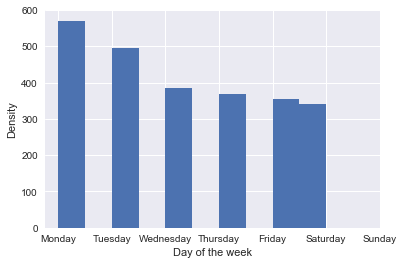

In [726]:
plt.hist(data.Date.dt.dayofweek)
plt.xticks(range(7),['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.xlabel('Day of the week')
plt.ylabel('Density')

plt.show()
